## PROJECT 1 MRI: diagnostic imaging SSY186

This project was worked by Robin Nilsson and Halldór Stefán Laxdal.

### Part P & A
Start by importing data from given mat file. 

In [31]:
%load_ext autoreload
%autoreload 2

In [79]:
import numpy as np
import scipy.io as sio
import os
import nibabel as nib
import matplotlib.pyplot as plt


if not os.path.exists('images'):
    os.makedirs('images')
if not os.path.exists('MRIdata.mat'):
    dataURL = "https://chalmers.instructure.com/courses/13290/files/1126239/download?wrap=1"
    r = requests.get(dataURL, allow_redirects=True)
    
img_id = 150 # image to test reconstruction methods

# P2
data = sio.loadmat('MRIdata.mat', struct_as_record=False)

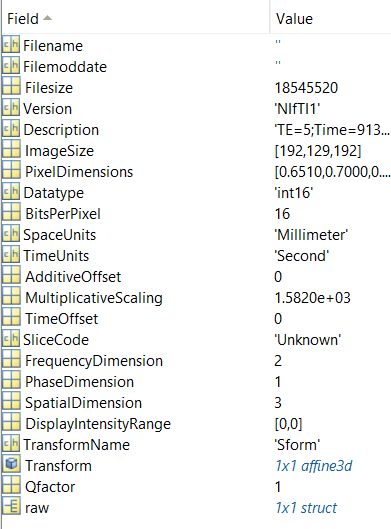

### Field of view
To calculate the FOV of the lens we will use the affine transform to transform the first pixel of the image and the last pixel, and then compare the distance between the two. 
As such the field of view is calculated as

FOV = pixels[end] * affine transform  -  pixels[0] * affine transform 

pixels[end] = [ImageSize * [pixel convertion to mili], 1]

pixels[0]   = [0, 0, 0, 1]

In [80]:
lens_data = (data['nifti_info'])[0,0]

affine = np.array([np.ndarray.flatten(lens_data.raw[0,0].srow_x),
                   np.ndarray.flatten(lens_data.raw[0,0].srow_y),
                   np.ndarray.flatten(lens_data.raw[0,0].srow_z),
                   [0,0,0,1]])

from nibabel.affines import apply_affine
FOV = apply_affine(affine, lens_data.ImageSize * lens_data.PixelDimensions) - apply_affine(affine, [0,0,0])
FOV

array([[58.78880799, 87.4996212 , 81.3802133 ]])

### Save image
Standardization for medical images is important. An algorithm or program should be able to correctly load and visualize the image otherwise correct treatment and/or diagnostic may be difficult or even impossible.  

In [81]:
# A2
from functions.filehandler import save_nifti_image, k2im

save_nifti_image(k2im(data['kspace_full']), 'test.nii', data['nifti_info'])

File 'test.nii' saved succesfully!


#### Slicer visualization

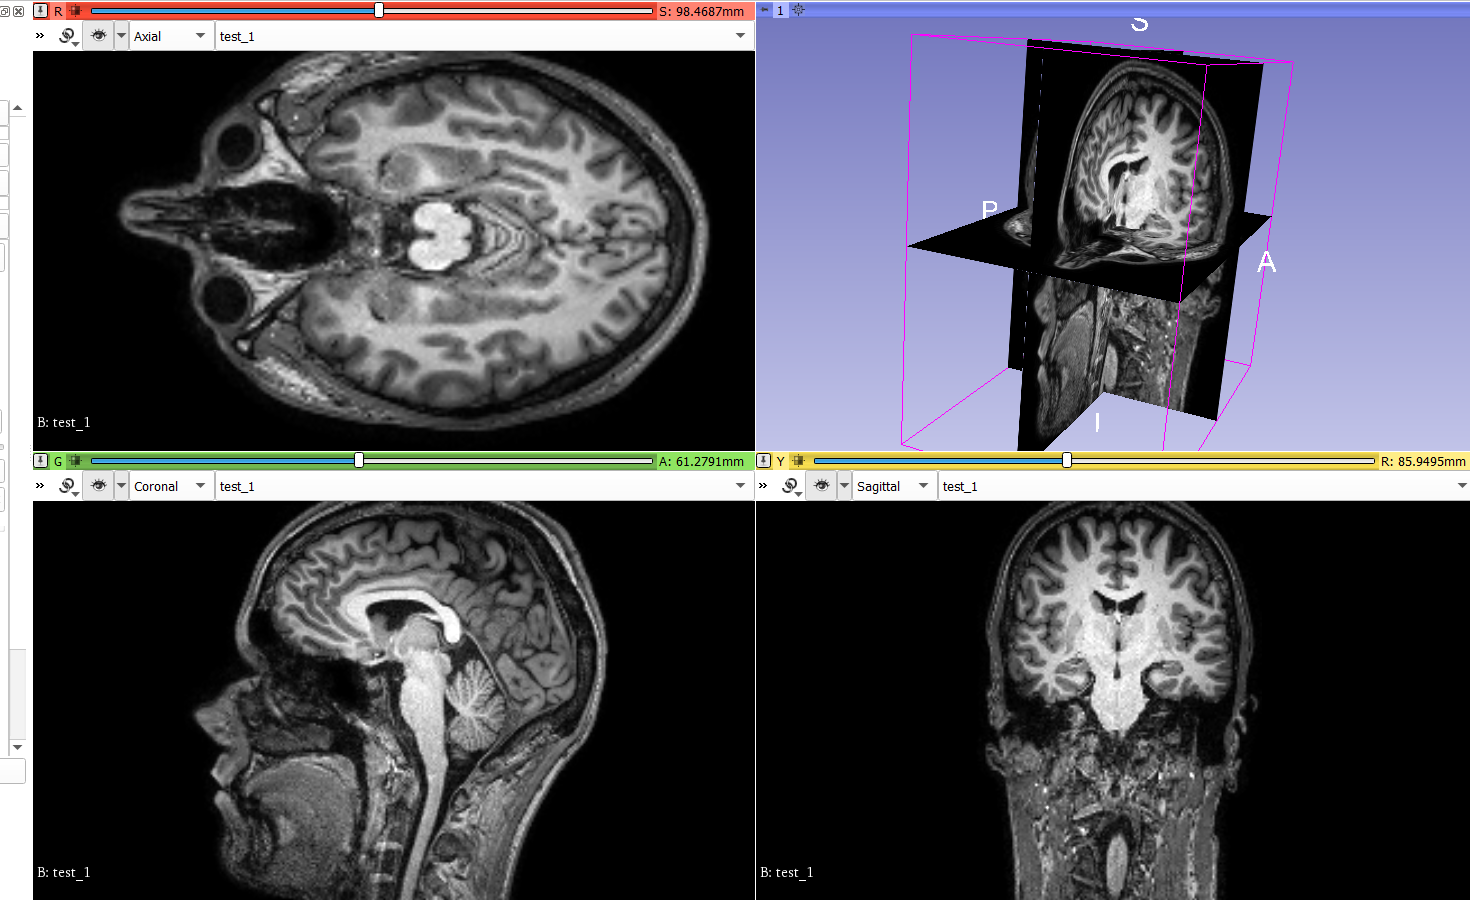

### Part B - Multi-coil reconstruction

In this section we use k-space data acquired by multiple coils.

#### B1
We reconstruct images from the k-space data for each coil separately. Below we can see the data from each coil as well as the coil sensitivity that accompanies each coil data.

In [82]:
# B1
kspace_coils = data['kspace_coils']

for i in range((kspace_coils.shape)[3]): # save image for each coil
    save_nifti_image(k2im(kspace_coils[:,:,:,i]), 'coil_' + str(i) + '.nii', data['nifti_info'])


File 'coil_0.nii' saved succesfully!
File 'coil_1.nii' saved succesfully!


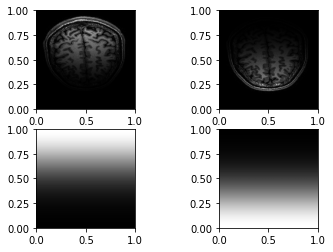

In [83]:
fig, axes = plt.subplots(2, (kspace_coils.shape)[3])
for i in range((kspace_coils.shape)[3]):
    img = nib.load('images/coil_' + str(i) + '.nii').get_fdata() # load image
    
    # add image to upper grid level
    axes[0,i].imshow(img[:,:,img_id],cmap='gray', extent=[0, 1, 0, 1]) 
    # add sensitivity to lower grid level
    axes[1,i].imshow((data['coil_sensitivities'])[:,:,img_id,i],cmap='gray', extent=[0, 1, 0, 1])

As demonstrated, each coil sensitivity map corresponds to the visible area of each coil. Light regions correspond to visible data while dark corresponds to attenuated or muted data. 

#### B2 
Here we combine different coil images into a single image using a sum of squares method. 

File 'coil_ssqr1.nii' saved succesfully!


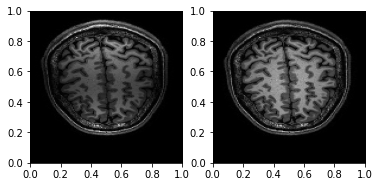

In [84]:
# B2
img_ssq = np.empty((kspace_coils.shape)[0:3]) # image sum square
for i in range((kspace_coils.shape)[3]): # sum over coils
    img = nib.load('images/coil_' + str(i) + '.nii').get_fdata()
    img_ssq += np.square(img) # add the square in the 'coil'-axis

    
fig, axes = plt.subplots(1, 2)

img_ssqr = np.sqrt(img_ssq)
axes[0].imshow(img_ssqr[:,:,],cmap='gray', extent=[0, 1, 0, 1])
save_nifti_image(img_ssqr[:,:,img_id], 'coil_ssqr' + str(i) + '.nii', data['nifti_info'])

img = nib.load('images/test.nii').get_fdata() # load image
axes[1].imshow(img[:,:,img_id],cmap='gray', extent=[0, 1, 0, 1]) 

The image acquired (left) is very similar to the one we acquire from part A (right). The image using coils though is darkend in the middle of the image, which is expected due to it being the furthest away place from the two coils. Barely the coil reconstructed image is brighter and with higher contrast closer to where the coils were placed (top-bottom) compared to the kspace_full image. 

#### B3 

In this section we propose a method to modify the coil-combination method introduced in B2. 

The modifed version uses a weighted-sum-of-squares principle compared to the previous version. The weights used is the inverse (1-mean) of the mean of the sensitivity maps. The weights is then applied as (1 - img*w)*img*w, which gave best effect by try and error. The idea of using the inverse mean is comes from that it should give the brightess part were the collective coils would be the darkest.   

The results when applied to the same slice as in the sum of squares method can be viewed below (left) in comparison with the sum of squares result (right).

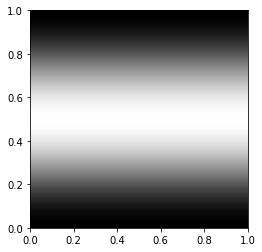

In [85]:
# B3

data['coil_sensitivities'].shape
weights = 1-np.mean(np.absolute(data['coil_sensitivities']), 3) 
# weights = (1+ normalized(weights))

plt.imshow(weights[:,:,img_id],cmap='gray', extent=[0, 1, 0, 1])

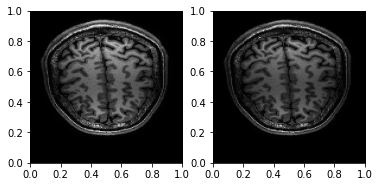

In [86]:
fig, axes = plt.subplots(1, 2)

img_ssqrw = np.sqrt((1-img_ssq*weights)*img_ssq*weights)

axes[0].imshow(img_ssqrw[:,:,img_id],cmap='gray', extent=[0, 1, 0, 1]) # modified version
axes[1].imshow(img_ssqr[:,:,img_id],cmap='gray', extent=[0, 1, 0, 1]) # sum-of-squares

The resulting image is very similar to the one acquired by sum of squares, but as seen brighter. Although it is hard to decipher if it has been more of a global illumination rather than a just the middle stipe. 

### Part C

In this part we use k-space data that has been subsampled with SENSE-factor 2.

#### C1 
We begin by reconstructing the images from the data from each separate coil. This yields warped and folded images of the organ that was being imaged. 

The aliasing in the folded images are due to the subsampling by each coil. By using more coils to sample sections of the k-space, we can take fewer samples per coil but more or equal in total by sampling parallely. Of course we can't infinitly add coils and get better results but this reduces the amount each coil has to sample. To remove tha aliasing and unfold/combine the seperate images one can eg. use the SENSE algorithm as we will do below. 

The images from each coil can be seen below and are compared to the corresponding reconstructions from part B.

File 'coilSubsamp_0.nii' saved succesfully!
File 'coilSubsamp_1.nii' saved succesfully!


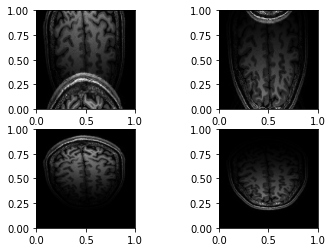

In [92]:
# C1
kspace_coils = data['kspace_subsampled']

rec_coils = np.empty(kspace_coils.shape, dtype='float').astype(complex)

for i in range((kspace_coils.shape)[3]): # save for each coil
    save_nifti_image(k2im(kspace_coils[:,:,:,i]), 'coilSubsamp_' + str(i) + '.nii', data['nifti_info'])

# plot grid of folded images (first row) vs the reconstructed images in B1 (second row)    
fig, axes = plt.subplots(2, (kspace_coils.shape)[3])
for i in range((kspace_coils.shape)[3]):
    img = nib.load('images/coilSubsamp_' + str(i) + '.nii') # load folded image
    axes[0,i].imshow(img.get_fdata()[:,:,img_id],cmap='gray', extent=[0, 1, 0, 1])
   
    img = nib.load('images/coil_' + str(i) + '.nii') # load reconstructed (B1) image
    axes[1,i].imshow(img.get_fdata()[:,:,img_id],cmap='gray', extent=[0, 1, 0, 1])

As before we see the effect of the using coils with different sensitivity maps where in the left image the coil is closer to the upper part of the image when scanned and thus have more brightness and contrast closer to the front of the brain. In the right closer to the bottom. We also notice how the aliases also keeps this property by eg. still being brighter in the front for the left image. 

#### C2
In order to properly reconstruct the parallel-sampled images, we implement a SENSE reconstruction algorithm, specifically for SENSE factor = 2. 

This implementation can be viewed in the $filehandler.py$ file. 

We apply this algorithm to the images we got from part C1, with their respective coil sensitivity maps.

The result can be viewed below. 

In [88]:
imgs_0 = nib.load('images/coilSubsamp_' + str(0) + '.nii').get_fdata()
imgs_1 = nib.load('images/coilSubsamp_' + str(1) + '.nii').get_fdata()

coil_imgs = np.empty(np.append(imgs_0.shape, 2), dtype='float')
coil_imgs[:,:,:,0] = imgs_0
coil_imgs[:,:,:,1] = imgs_1

coil_sensitivities = data['coil_sensitivities']

from functions.filehandler import SENSE

sol = SENSE(coil_imgs, coil_sensitivities)

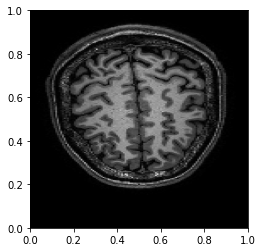

In [89]:
plt.imshow(abs(sol[:,:,img_id]), cmap='gray', extent=[0, 1, 0, 1]) # plot solution